In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


# Import the data
df = pd.read_excel('Data\data_to_model_adj.xls', '1.2')

print(df.head(5))
print(df.tail(10))

   year  month  electricity_available
0  1995      1                  28.50
1  1995      2                  27.88
2  1995      3                  33.33
3  1995      4                  23.88
4  1995      5                  22.61
     year  month  electricity_available
296  2019      9              22.750587
297  2019     10              26.098706
298  2019     11              28.009951
299  2019     12              28.340429
300  2020      1              29.155059
301  2020      2              26.936729
302  2020      3              26.456071
303  2020      4              20.781664
304  2020      5              20.618286
305  2020      6              20.447937


In [2]:
# Remove rows from year 2020 to capture pre-covid trend
df.drop(305, axis=0,inplace=True)
df.drop(304, axis=0,inplace=True)
df.drop(303, axis=0,inplace=True)
df.drop(302, axis=0,inplace=True)
df.drop(301, axis=0,inplace=True)
df.drop(300, axis=0,inplace=True)

print(df.tail(5))

     year  month  electricity_available
295  2019      8              22.614905
296  2019      9              22.750587
297  2019     10              26.098706
298  2019     11              28.009951
299  2019     12              28.340429


In [3]:
# Create column that combines year and month
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

# Convert to datetime
df['year_month'] = pd.to_datetime(df['year_month'])

# Set date column as index
df.set_index('year_month',inplace=True)

# Remove no longer required columns
df = df.drop(columns=['year', 'month'])

print(df.head())

            electricity_available
year_month                       
1995-01-01                  28.50
1995-02-01                  27.88
1995-03-01                  33.33
1995-04-01                  23.88
1995-05-01                  22.61


In [4]:
# Print the descriptive statistics
print(df.describe())

       electricity_available
count             300.000000
mean               28.037589
std                 3.507795
min                21.130000
25%                25.416680
50%                27.637955
75%                30.269750
max                37.457000


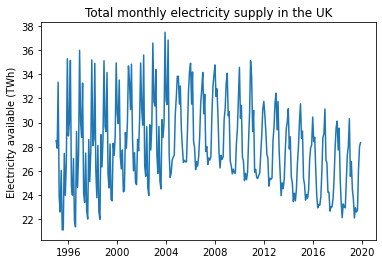

In [5]:
# View the historical data plot

plt.plot(df)
plt.title("Total monthly electricity supply in the UK")
plt.ylabel("Electricity available (TWh)")
plt.show()

In [6]:
### Testing For Stationarity

test_result = adfuller(df['electricity_available'])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(electricity_available):
    result = adfuller(electricity_available)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adfuller_test(df['electricity_available'])


ADF Test Statistic : -0.1095848735477764
p-value : 0.9484754348833275
#Lags Used : 14
Number of Observations Used : 285
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


year_month
1995-01-01    28.50
1995-02-01    27.88
1995-03-01    33.33
1995-04-01    23.88
1995-05-01    22.61
Name: electricity_available, dtype: float64
year_month
1995-01-01          NaN
1995-02-01    28.500000
1995-03-01    27.880000
1995-04-01    33.330000
1995-05-01    23.880000
                ...    
2019-08-01    22.956492
2019-09-01    22.614905
2019-10-01    22.750587
2019-11-01    26.098706
2019-12-01    28.009951
Name: electricity_available, Length: 300, dtype: float64
            electricity_available  electricity_available First Difference  \
year_month                                                                  
1995-01-01                  28.50                                     NaN   
1995-02-01                  27.88                                   -0.62   
1995-03-01                  33.33                                    5.45   
1995-04-01                  23.88                                   -9.45   
1995-05-01                  22.61                  

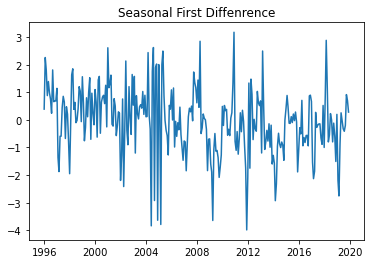

<Figure size 864x576 with 0 Axes>

In [7]:
### Differencing

print(df['electricity_available'].head())
df['electricity_available First Difference'] = df['electricity_available'] - df['electricity_available'].shift(1)
print(df['electricity_available'].shift(1))
df['Seasonal First Difference'] = df['electricity_available'] - df['electricity_available'].shift(12)

print(df.head(14))

## Again test Dickey Fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

plt.plot(df['Seasonal First Difference'])
plt.title("Seasonal First Diffenrence")
plt.figure(figsize=(12,8))
plt.show()

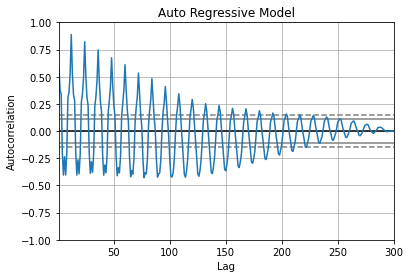

<Figure size 864x576 with 0 Axes>

In [8]:
# Auto Regressive Model

autocorrelation_plot(df['electricity_available'])

plt.title("Auto Regressive Model")
plt.figure(figsize=(12,8))
plt.show()

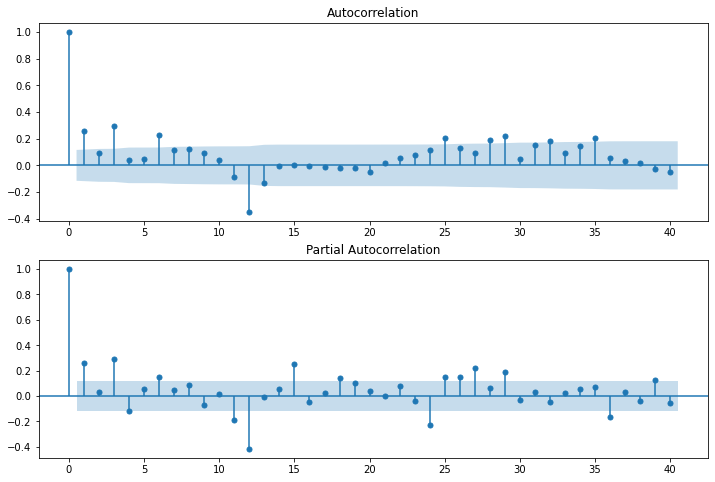

In [9]:
# Autocorrelation and Partial Autocorrelation

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

plt.show()

In [10]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

model = ARIMA(df['electricity_available'], order=(1,1,1))
model_fit = model.fit()


c:\users\44790\documents\coding\code first python\project\bigdatachallenge\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\44790\documents\coding\code first python\project\bigdatachallenge\venv\lib\site-packages\statsmode

In [11]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                
===================================================================================
Dep. Variable:     D.electricity_available   No. Observations:                  299
Model:                      ARIMA(1, 1, 1)   Log Likelihood                -761.611
Method:                            css-mle   S.D. of innovations              3.090
Date:                     Fri, 18 Sep 2020   AIC                           1531.223
Time:                             01:11:22   BIC                           1546.025
Sample:                         02-01-1995   HQIC                          1537.147
                              - 12-01-2019                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0018      0.126     -0.014      0.989      -0.248       0.244
ar.L1.D.electricity_available    -0.0454      0.141     -0.323      0.747      -0.321       0.230
ma.L1.D.electricity_available    -0.2660      0.130     -2.043      0.041      -0.521      -0.011
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -22.0224           +0.0000j           22.0224            0.5000
MA.1            3.7599           +0.0000j            3.7599            0.0000
-----------------------------------------------------------------------------
"""

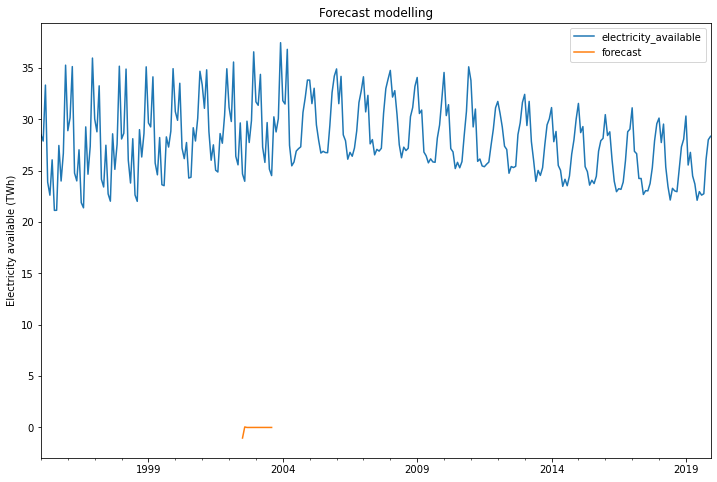

In [12]:
# Forecast modelling 

df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['electricity_available','forecast']].plot(figsize=(12,8))

plt.title("Forecast modelling")
plt.ylabel("Electricity available (TWh)")
plt.xlabel("")
plt.show()

c:\users\44790\documents\coding\code first python\project\bigdatachallenge\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\44790\documents\coding\code first python\project\bigdatachallenge\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


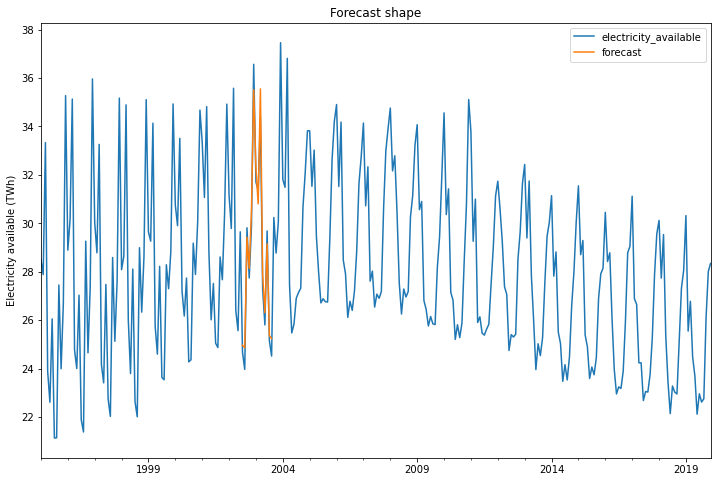

In [13]:
# Modelling the forecast shape

model=sm.tsa.statespace.SARIMAX(df['electricity_available'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['electricity_available','forecast']].plot(figsize=(12,8))

plt.title("Forecast shape")
plt.ylabel("Electricity available (TWh)")
plt.xlabel("")
plt.show()

In [14]:
# Estimating future movements 

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

print(future_datest_df.tail())

future_df=pd.concat([df,future_datest_df])

           electricity_available electricity_available First Difference  \
2021-07-01                   NaN                                    NaN   
2021-08-01                   NaN                                    NaN   
2021-09-01                   NaN                                    NaN   
2021-10-01                   NaN                                    NaN   
2021-11-01                   NaN                                    NaN   

           Seasonal First Difference forecast  
2021-07-01                       NaN      NaN  
2021-08-01                       NaN      NaN  
2021-09-01                       NaN      NaN  
2021-10-01                       NaN      NaN  
2021-11-01                       NaN      NaN  


Text(0, 0.5, 'Electricity available (TWh)')

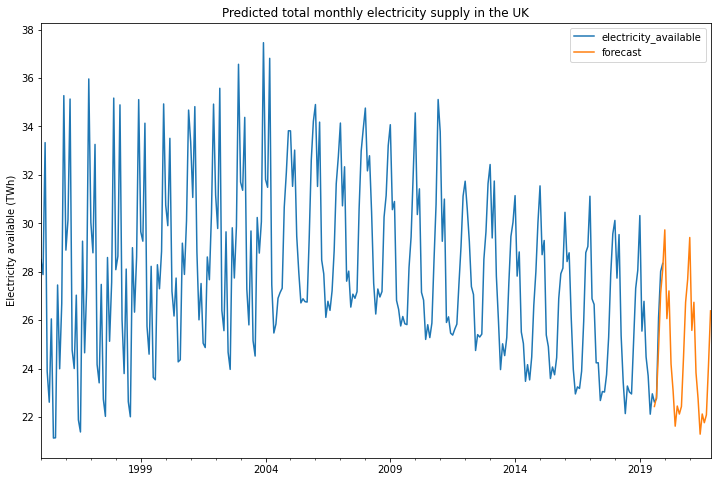

In [15]:
# Set the start and end points of the prediction

future_df['forecast'] = results.predict(start = 295, end = 700, dynamic= True)
future_df[['electricity_available', 'forecast']].plot(figsize=(12, 8))

plt.title("Predicted total monthly electricity supply in the UK")
plt.ylabel("Electricity available (TWh)")
